# Dantzig-Fulkerson-Johnson (DFJ) TSP Results Analysis

This notebook analyzes the integrality gap results from the DFJ formulation experiments.

**Method**: The integrality gap compares:
- **IP**: Optimal TSP tour using lazy subtour elimination
- **LP (Held-Karp relaxation)**: Same constraints as IP, but with continuous variables

**References**:
- Held-Karp relaxation (Subtour Elimination Problem - SEP)
- [arXiv:2507.07003 - The Integrality Gap of the TSP](https://arxiv.org/abs/2507.07003)

## 1. Import dependency needed

Import dependencies needed for analyse and setup the pandas display

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# make pandas dataframes display better in outputs
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 2. Load Data

Load the experimental results from the CSV file `dfj_results.csv` generated by `run_dfj_experiments.py`. If encounter any problem, run `python run_dfj_experiments.py` first.

In [16]:
# Load results
results_df = pd.read_csv("dfj_results.csv")

print(f"Total instances: {len(results_df)}")
print(f"\nProblem sizes: {sorted(results_df['n'].unique())}")
print(f"Structures: {sorted(results_df['structure'].unique())}")
print(f"Instances per structure: {results_df.groupby(['n', 'structure']).size().iloc[0]}")

results_df.head()

Total instances: 120

Problem sizes: [np.int64(15), np.int64(18), np.int64(20)]
Structures: ['clustered', 'grid', 'hub_spoke', 'random']
Instances per structure: 10


,n,structure,instance_idx,instance,IP_obj,LP_obj,gap_absolute,gap_percent,cv,ip_solve_time,lp_solve_time,total_solve_time
0,15,grid,0,dist_n15_grid_i0.csv,770.207345,770.207345,0.000000e+00,0.000000e+00,0.401085,0.064245,0.004986,0.069231
1,15,grid,1,dist_n15_grid_i1.csv,770.536657,770.536657,0.000000e+00,0.000000e+00,0.401132,0.006695,0.003476,0.010171
2,15,grid,2,dist_n15_grid_i2.csv,770.548027,770.526469,2.155822e-02,2.797778e-03,0.401123,0.021381,0.004595,0.025976
3,15,grid,3,dist_n15_grid_i3.csv,770.511689,770.511689,0.000000e+00,0.000000e+00,0.401146,0.008937,0.004796,0.013733
4,15,grid,4,dist_n15_grid_i4.csv,770.367498,770.367498,-1.136868e-13,-1.475748e-14,0.401134,0.006831,0.004467,0.011298


## 3. Summary Statistics

Calculate summary statistics for each problem size and structure. 

Note that DFJ gaps are expected to be very small because we use the same subtour elimination constraints from the IP solve in the LP relaxation (Held-Karp bound). These targeted constraints create a very tight LP relaxation.

In [17]:
summary = results_df.groupby(['structure', 'n']).agg({
    'gap_percent': ['mean', 'std', 'min', 'max'],
    'cv': ['mean', 'std'],
    'ip_solve_time': ['mean', 'max'],
    'lp_solve_time': ['mean', 'max'],
    'total_solve_time': ['mean', 'max']
}).round(4)

summary

gap_percent                           cv         ip_solve_time         lp_solve_time         total_solve_time        
                    mean     std  min     max    mean     std          mean     max          mean     max             mean     max
structure n                                                                                                                       
clustered 15     -0.0000  0.0000 -0.0  0.0000  0.6404  0.0692        0.0076  0.0111        0.0048  0.0051           0.0124  0.0152
          18     -0.0000  0.0000 -0.0  0.0000  0.6244  0.0742        0.0099  0.0160        0.0061  0.0073           0.0159  0.0230
          20      0.0249  0.0530 -0.0  0.1406  0.6233  0.0740        0.0124  0.0169        0.0072  0.0084           0.0196  0.0254
grid      15      0.0006  0.0012 -0.0  0.0029  0.4011  0.0000        0.0147  0.0642        0.0043  0.0062           0.0190  0.0692
          18     -0.0000  0.0000 -0.0  0.0000  0.4306  0.0000        0.0074  0.0085        0.0051  0.0065           0.0125  0.0149
          20      0.0009  0.0028  0.0  0.0089  0.4260  0.0000        0.0106  0.0121        0.0072  0.0091           0.0178  0.0201
hub_spoke 15      0.0000  0.0000  0.0  0.0000  0.6760  0.0095        0.0066  0.0095        0.0041  0.0052           0.0107  0.0145
          18      0.0000  0.0000 -0.0  0.0000  0.6487  0.0074        0.0083  0.0092        0.0056  0.0068           0.0139  0.0150
          20      0.1377  0.3527 -0.0  1.1132  0.6488  0.0086        0.0159  0.0311        0.0130  0.0315           0.0289  0.0459
random    15      0.0945  0.2165 -0.0  0.6526  0.4596  0.0244        0.0100  0.0237        0.0046  0.0056           0.0146  0.0285
          18      0.1309  0.3541 -0.0  1.1253  0.4594  0.0204        0.0107  0.0180        0.0056  0.0078           0.0163  0.0254
          20      0.3491  0.5832 -0.0  1.5367  0.4711  0.0198        0.0150  0.0247        0.0093  0.0196           0.0243  0.0320

In [19]:
# Overall statistics by structure (across all sizes)
overall_summary = results_df.groupby('structure').agg({
    'gap_percent': ['mean', 'std', 'min', 'max'],
    'cv': 'mean',
    'total_solve_time': 'mean',
}).round(4)

overall_summary

gap_percent                           cv total_solve_time
                 mean     std  min     max    mean             mean
structure                                                          
clustered      0.0083  0.0318 -0.0  0.1406  0.6294           0.0160
grid           0.0005  0.0017 -0.0  0.0089  0.4192           0.0164
hub_spoke      0.0459  0.2073 -0.0  1.1132  0.6578           0.0179
random         0.1915  0.4148 -0.0  1.5367  0.4634           0.0184

## 4. Visualization: Gap Distribution by Structure

Box plot showing how the integrality gap varies across different problem structures, here we focus on n = 20.

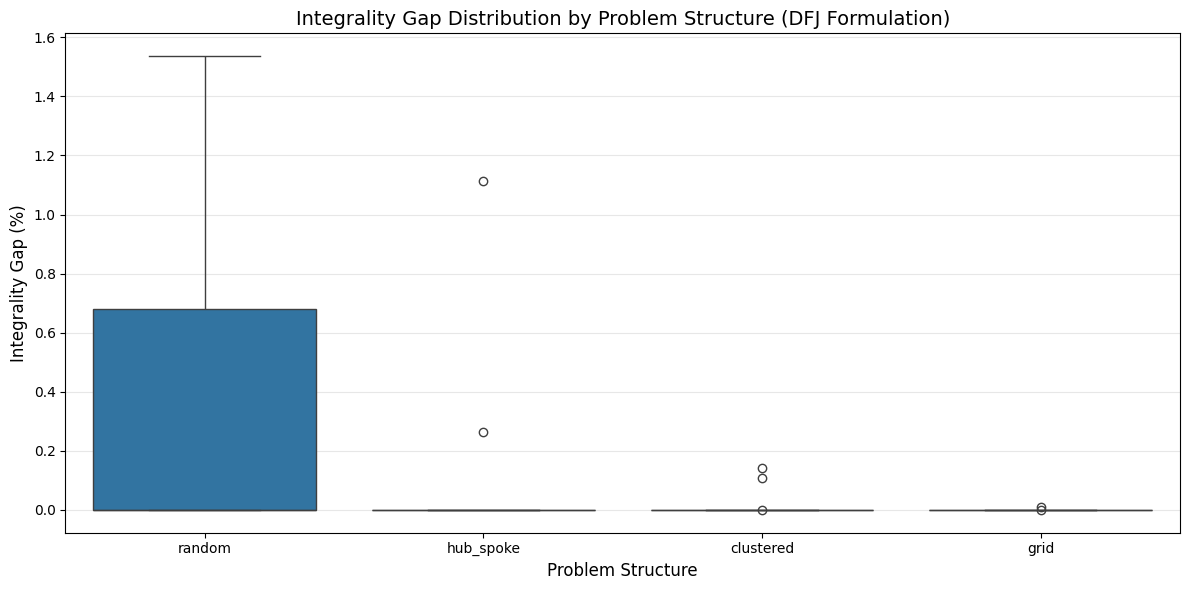

In [20]:
plt.figure(figsize=(12, 6))

data_n20 = results_df[results_df['n'] == 20]
# Sort structures by mean gap for better visualization
structure_order = data_n20.groupby('structure')['gap_percent'].mean().sort_values(ascending=False).index

sns.boxplot(data=data_n20, x='structure', y='gap_percent', order=structure_order)
plt.xlabel('Problem Structure', fontsize=12)
plt.ylabel('Integrality Gap (%)', fontsize=12)
plt.title('Integrality Gap Distribution by Problem Structure (DFJ Formulation)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Visualization: Gap by Problem Size

Compare how the gap changes with problem size n for each structure.

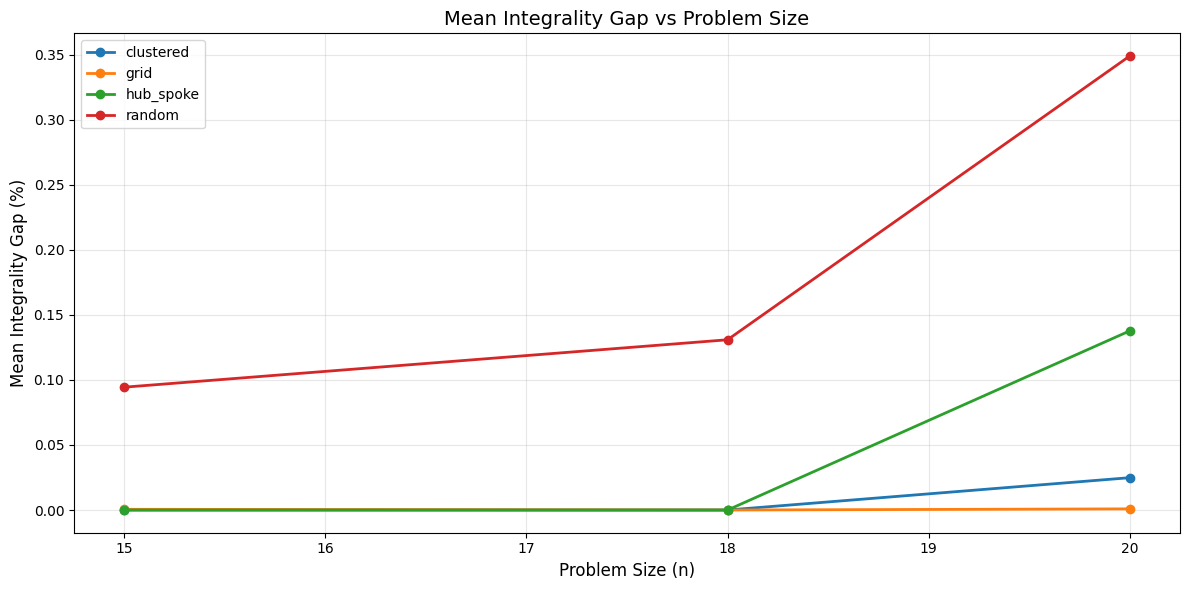

In [21]:
plt.figure(figsize=(12, 6))

gap_by_size = results_df.groupby(['n', 'structure'])['gap_percent'].mean().reset_index()

for structure in sorted(results_df['structure'].unique()):
    data = gap_by_size[gap_by_size['structure'] == structure]
    plt.plot(data['n'], data['gap_percent'], marker='o', label=structure, linewidth=2)

plt.xlabel('Problem Size (n)', fontsize=12)
plt.ylabel('Mean Integrality Gap (%)', fontsize=12)
plt.title('Mean Integrality Gap vs Problem Size', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualization: IP vs LP Objectives

Scatter plot showing the relationship between LP relaxation and IP optimal values.

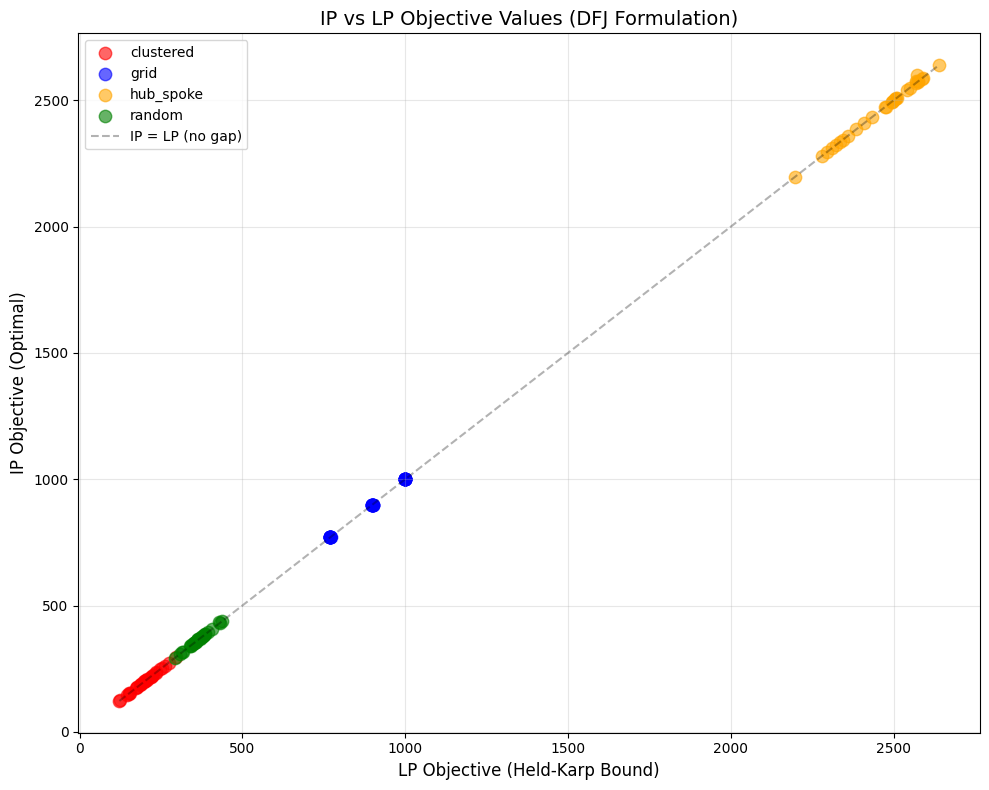

In [22]:
plt.figure(figsize=(10, 8))

colors = {'grid': 'blue', 'random': 'green', 'clustered': 'red', 'hub_spoke': 'orange'}

for structure in sorted(results_df['structure'].unique()):
    df_struct = results_df[results_df['structure'] == structure]
    plt.scatter(df_struct['LP_obj'], df_struct['IP_obj'],
               label=structure, alpha=0.6, s=80, color=colors.get(structure, 'gray'))

# Add diagonal line (IP = LP would be on this line)
min_val = min(results_df['LP_obj'].min(), results_df['IP_obj'].min())
max_val = max(results_df['LP_obj'].max(), results_df['IP_obj'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='IP = LP (no gap)')

plt.xlabel('LP Objective (Held-Karp Bound)', fontsize=12)
plt.ylabel('IP Objective (Optimal)', fontsize=12)
plt.title('IP vs LP Objective Values (DFJ Formulation)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Statistical Analysis
Perform statistical hypothese tests to determine if gaps differ significantly across structures.

In [23]:
# ANOVA test to check if mean gaps differ across structures
groups = [results_df[results_df['structure'] == s]['gap_percent'].values 
          for s in results_df['structure'].unique()]

f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA Test Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"\nConclusion: Gaps {'differ significantly' if p_value < 0.05 else 'do not differ significantly'} across structures (α=0.05)")

ANOVA Test Results:
F-statistic: 4.3855
P-value: 0.005811

Conclusion: Gaps differ significantly across structures (α=0.05)


## 9. Key Findings

Summarize the main observations from the analysis for only n=20. remove the data filter at the start if want to compare cross n

In [28]:
# Calculate key metrics
results_df = results_df[results_df['n'] == 20]
structure_gaps = results_df.groupby('structure')['gap_percent'].mean().sort_values(ascending=False)
largest_gap_structure = structure_gaps.index[0]
smallest_gap_structure = structure_gaps.index[-1]

print(f"\n1. Largest mean gap: {largest_gap_structure} ({structure_gaps.iloc[0]:.2f}%)")
print(f"2. Smallest mean gap: {smallest_gap_structure} ({structure_gaps.iloc[-1]:.2f}%)")
print(f"3. Overall mean gap: {results_df['gap_percent'].mean():.2f}%")
print(f"4. Gap range: {abs(results_df['gap_percent'].min()):.2f}% - {results_df['gap_percent'].max():.2f}%")
print(f"5. Mean LP solve time: {results_df['total_solve_time'].mean():.4f} seconds")
print(f"\n6. Gap by structure:")
for structure, gap in structure_gaps.items():
    print(f"   - {structure}: {gap:.2f}%")


1. Largest mean gap: random (0.35%)
2. Smallest mean gap: grid (0.00%)
3. Overall mean gap: 0.13%
4. Gap range: 0.00% - 1.54%
5. Mean LP solve time: 0.0227 seconds

6. Gap by structure:
   - random: 0.35%
   - hub_spoke: 0.14%
   - clustered: 0.02%
   - grid: 0.00%
